# KSKL

In [5]:
import sys
sys.path.append('../notebooks/')

In [57]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from glob import glob

import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [46]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad']*df['dccorr'])
    cs_born_err = cs_born*df['rad']*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        (df['lum_err']/df['lum'])**2 + (df['eff0_err']/df['eff0'])**2 + (df['eff_trig_err']/df['eff_trig'])**2 + 
                                           (df['dccorr_err']/df['dccorr'])**2) #не делю на рад.поправку
    return (cs_born, cs_born_err)
def get_cs(season, dropna=False):
    df_signal = pd.read_csv(f'../data/{season}/results/signal.csv', index_col=0)
    df_reg_eff = pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0)
    df_triggers = pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0)
    df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
    df_dc = pd.read_csv(f'../data/{season}/results/dc.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/dc.csv') else pd.DataFrame({'dccorr': 1, 'dccorr_err': 0}, index=df_signal.index)
    df_rads = pd.read_csv(f'../data/{season}/results/radcors.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/radcors.csv') else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df_signal.index)
    df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_dc, df_rads], axis=1)
    df.rad.fillna(1, inplace=True)
    df.rad_err.fillna(0, inplace=True)
    df['cs_born'], df['cs_born_err'] = calc_cs_born(df)
    df['season'] = season
    if dropna:
        df.dropna(inplace=True)
    return df

In [49]:
crosses = {
    '11': get_cs('11'),
    '12': get_cs('12'),
    '17': get_cs('17'),
    '19': get_cs('19'),
    '20': get_cs('20'),
}

1. Фит теперь не по инв массе, а по оси корреляции

In [7]:
exp_tree = uproot.open(f'../trees/12/exp.root')['t']
mc_tree = uproot.open(f'../trees/12/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False)
df_mc = preprocess.read_tree(mc_tree, mc=True)

In [10]:
energy = 800

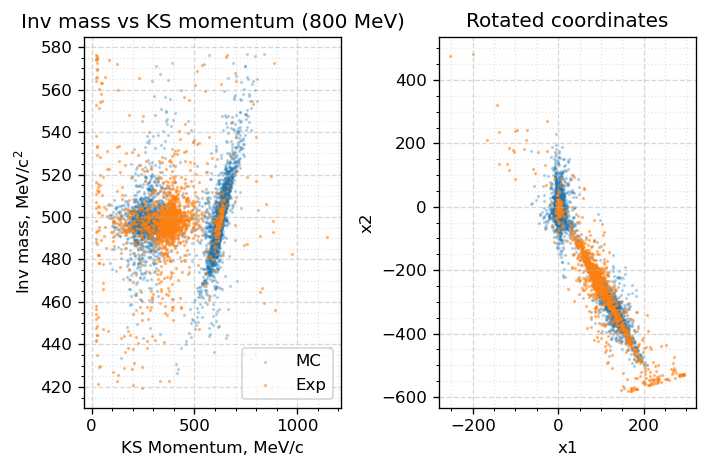

In [28]:
df_temp_exp, df_temp_mc = df_exp.loc[energy], df_mc.loc[energy]

plt.subplot(121)
plt.scatter(df_temp_mc.ksptot, df_temp_mc.ksminv, s=1, alpha=0.25, label='MC')
plt.scatter(df_temp_exp.ksptot, df_temp_exp.ksminv, s=1, alpha=0.45, label='Exp')
pys.my_style(f'Inv mass vs KS momentum ({energy} MeV)', legend=True,
             xtitle='KS Momentum, MeV/c', ytitle='Inv mass, MeV/c${}^2$');

plt.subplot(122)
plt.scatter(df_temp_mc.x1, df_temp_mc.x2, s=1, alpha=0.25, label='MC')
plt.scatter(df_temp_exp.x1, df_temp_exp.x2, s=1, alpha=0.45, label='Exp')
pys.my_style('Rotated coordinates', xtitle='x1', ytitle='x2');

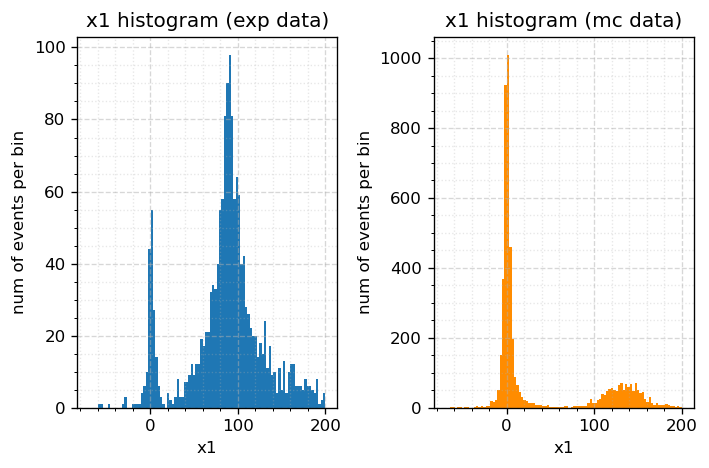

In [45]:
hist_range = (-70, 200)

plt.subplot(121)
plt.hist(df_temp_exp.x1, bins=100, range=hist_range);
pys.my_style('x1 histogram (exp data)', 
             xtitle='x1', ytitle='num of events per bin');

plt.subplot(122)
plt.hist(df_temp_mc.x1, bins=100, range=hist_range, color='darkorange');
pys.my_style('x1 histogram (mc data)', 
             xtitle='x1', ytitle='num of events per bin');

2. Посмотрел на `multihadrons`
![](./sources/study/multics.png)

3. Новая фит-функция

![](./sources/study/cruijff.png)

$p = N_{sig} \cdot f(x; m_0, ...) + N_{bkg} \cdot ( kx + b )$

$\int_{x_{min}}^{x_{max}}(kx+b)dx = 1$

![](./sources/study/exp17_880.png)
![](./sources/study/mc17_880.png )

4. Эффективность регистрации, радпоправка и триггеры

![](./sources/study/regeff17.png )

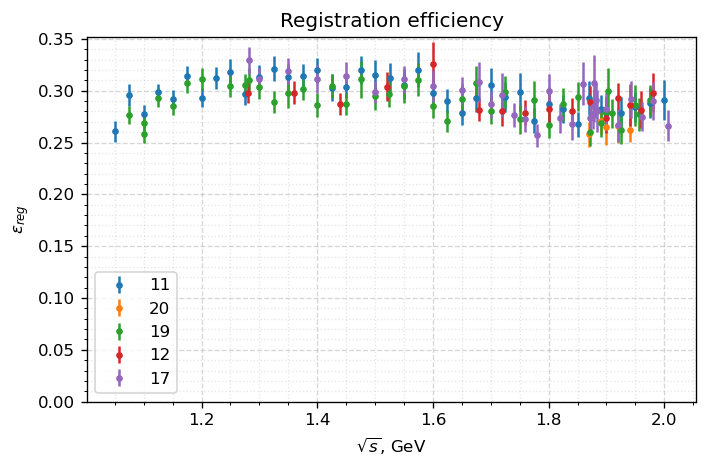

In [62]:
dfs_reg = {re.findall(r'data/(.*)/results', i)[0] : pd.read_csv(i, index_col=0) for i in glob('../data/*/results/reg_eff.csv')}
for key in dfs_reg:
    plt.errorbar(dfs_reg[key].index*2e-3, dfs_reg[key].eff0, 
                 yerr=dfs_reg[key].eff0_err, fmt='.', label=key)
pys.my_style('Registration efficiency', xtitle='$\\sqrt{s}$, GeV', ytitle='$\\varepsilon_{reg}$', legend=True,
            ylim=(0, None))

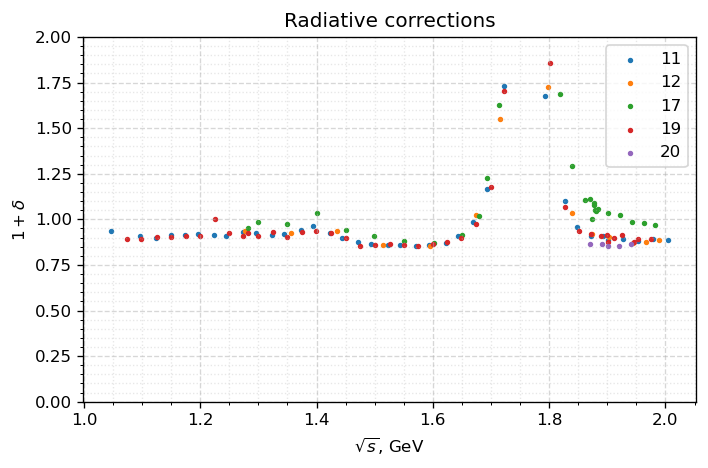

In [71]:
for k in crosses:
    plt.scatter(crosses[k]['emeas']*2e-3, crosses[k]['rad'], s=5, label=k)
pys.my_style('Radiative corrections', legend=True, xtitle='$\sqrt{s}$, GeV',
            ytitle='$1+\delta$', ylim=(0, 2))

5. Поправка на ДК

6. Сечения

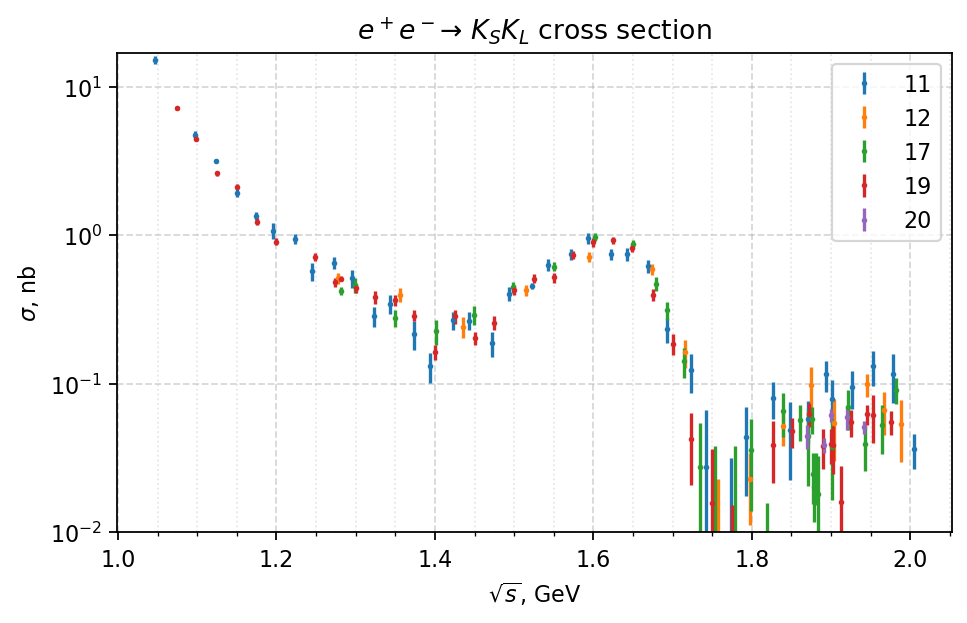

In [50]:
fig, ax = plt.subplots(dpi=160)
for cs in crosses:
    ax.errorbar(crosses[cs].emeas*2e-3, crosses[cs].cs_born, yerr=crosses[cs].cs_born_err, fmt='.', label=cs, ms=3)
pys.my_style(title='$e^+e^- \\to \ K_SK_L$ cross section', xtitle='$\sqrt{s}$, GeV', ytitle='$\sigma$, nb', ylim=(1e-2, None), legend=True)
ax.set_yscale('symlog', linthresh=1e-3)